Using device: cuda
Number of GPUs available: 1
GPU Name: NVIDIA GeForce MX250
Number of classes: 6
Classes: ['10_centavos', '1_boliviano', '20_centavos', '2_bolivianos', '50_centavos', '5_bolivianos']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.4303221..1.82].


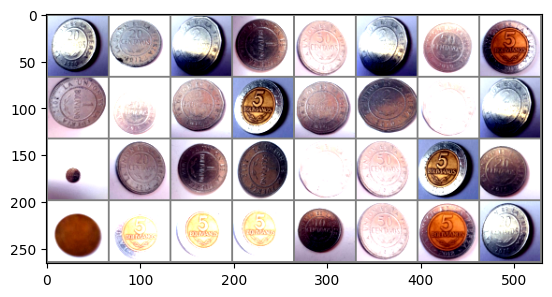

In [11]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import torch.nn.functional as F  # Importar torch.nn.functional como F

# Verificar si CUDA está disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

if torch.cuda.is_available():
    print(f"Number of GPUs available: {torch.cuda.device_count()}")
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")

# Configurar transformaciones para las imágenes
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Cambiar el tamaño de las imágenes a 64x64
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Definir rutas del dataset
train_folder = r"D:\CESAR\Universidad\7mo semestre\SIS 420\repositorio\Examen Final\dataset\train"
test_folder = r"D:\CESAR\Universidad\7mo semestre\SIS 420\repositorio\Examen Final\dataset\test"

# Cargar datasets
train_dataset = datasets.ImageFolder(root=train_folder, transform=transform)
test_dataset = datasets.ImageFolder(root=test_folder, transform=transform)

batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Verificar el número de clases en el dataset de entrenamiento
num_classes = len(train_dataset.classes)
print(f"Number of classes: {num_classes}")
print(f"Classes: {train_dataset.classes}")

# Mostrar algunas imágenes del dataset
def imshow(img):
    img = img / 2 + 0.5  # desnormalizar
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Obtener algunas imágenes de entrenamiento
dataiter = iter(train_loader)
images, labels = next(dataiter)  # Cambiado a next(dataiter)

# Mostrar imágenes
imshow(torchvision.utils.make_grid(images))

In [12]:
class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.dropout = nn.Dropout(0.5)  # Añadir dropout con probabilidad de 0.5
        self.fc1 = nn.Linear(64 * 16 * 16, 128)  # Ajustar el tamaño de entrada
        self.fc2 = nn.Linear(128, num_classes)  # Número de clases

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # Convolución + ReLU + Pooling
        x = self.pool(F.relu(self.conv2(x)))  # Convolución + ReLU + Pooling
        x = x.view(-1, 64 * 16 * 16)  # Aplanar el tensor
        x = self.dropout(F.relu(self.fc1(x)))  # Capa completamente conectada + ReLU + Dropout
        x = self.fc2(x)  # Capa completamente conectada (salida)
        return x

# Inicializar el modelo, la función de pérdida y el optimizador
model = CNN(num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)  # Añadir weight decay

# Mover el modelo a la GPU si está disponible
model.to(device)

CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=16384, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=6, bias=True)
)

In [13]:
num_epochs = 20  # Puedes ajustar el número de epochs
train_losses = []
test_accuracies = []
best_accuracy = 0.0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # Mover datos a la GPU
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_losses.append(running_loss / len(train_loader))
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}")

    # Evaluar el modelo en el conjunto de prueba
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Mover datos a la GPU
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    test_accuracies.append(accuracy)
    print(f"Test Accuracy: {accuracy}%")

    # Guardar el mejor modelo
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        torch.save(model.state_dict(), 'best_model.pth')
        print(f"Saved Best Model with Accuracy: {best_accuracy}%")

Epoch 1/20, Loss: 0.13501526169605238
Test Accuracy: 99.62083976969527%
Saved Best Model with Accuracy: 99.62083976969527%
Epoch 2/20, Loss: 0.02462539161230313
Test Accuracy: 99.94382811402893%
Saved Best Model with Accuracy: 99.94382811402893%
Epoch 3/20, Loss: 0.01476844337243689
Test Accuracy: 99.91574217104339%
Epoch 4/20, Loss: 0.021980000626195973
Test Accuracy: 100.0%
Saved Best Model with Accuracy: 100.0%
Epoch 5/20, Loss: 0.009695010515918345
Test Accuracy: 99.85957028507232%
Epoch 6/20, Loss: 0.010870010593251421
Test Accuracy: 99.88765622805786%
Epoch 7/20, Loss: 0.008781266976194333
Test Accuracy: 100.0%
Epoch 8/20, Loss: 0.012311451078337034
Test Accuracy: 99.98595702850723%
Epoch 9/20, Loss: 0.006107471309084971
Test Accuracy: 99.98595702850723%
Epoch 10/20, Loss: 0.008541436461013244
Test Accuracy: 100.0%
Epoch 11/20, Loss: 0.003901299072360998
Test Accuracy: 99.94382811402893%
Epoch 12/20, Loss: 0.0063284411290451805
Test Accuracy: 100.0%
Epoch 13/20, Loss: 0.004037451

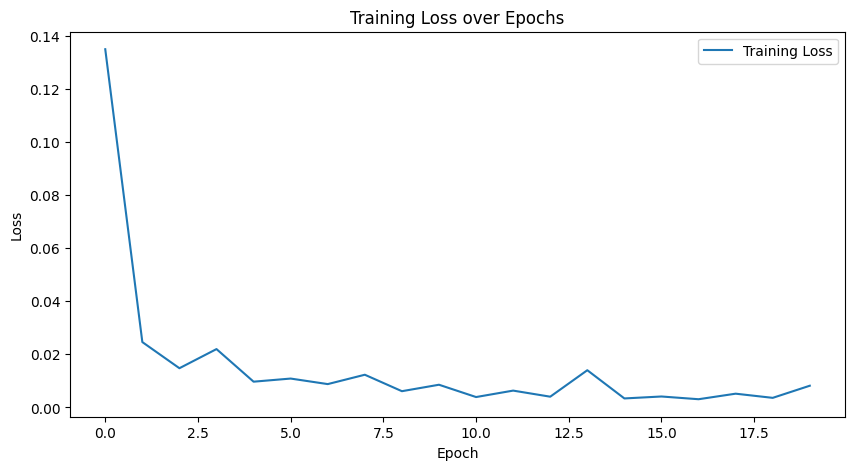

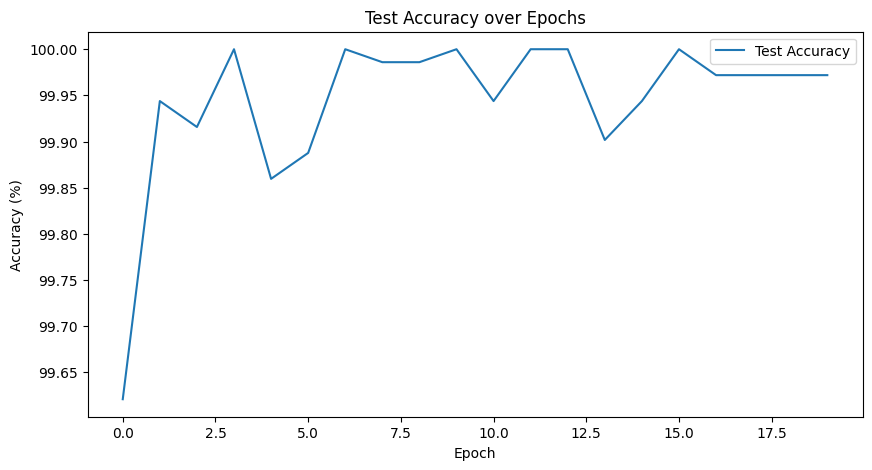

In [14]:
# Graficar la pérdida de entrenamiento
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

# Graficar la precisión de prueba
plt.figure(figsize=(10, 5))
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy over Epochs')
plt.legend()
plt.show()

In [15]:
# Cargar el mejor modelo
model = CNN(num_classes)
model.load_state_dict(torch.load('best_model.pth'))
model.to(device)  # Mover el modelo a la GPU si está disponible
model.eval()

# Evaluar el modelo en el conjunto de prueba
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # Mover datos a la GPU
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Final Test Accuracy: {accuracy}%")

C:\Users\cesar\AppData\Local\Temp\ipykernel_4300\3078137661.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


Final Test Accuracy: 100.0%


In [19]:
from PIL import Image

def predict_image(image_path, model, transform):
    image = Image.open(image_path)
    image = transform(image).unsqueeze(0).to(device)  # Mover la imagen a la GPU si está disponible
    model.eval()
    with torch.no_grad():
        output = model(image)
        _, predicted = torch.max(output, 1)
    return train_dataset.classes[predicted.item()]

# Predecir una nueva imagen
image_path = r"D:\CESAR\Universidad\7mo semestre\SIS 420\repositorio\Examen Final\prueba\1_peso.jpg"
predicted_class = predict_image(image_path, model, transform)
print(f"Predicted class: {predicted_class}")

Predicted class: 10_centavos
